#WGANs (Wasserstein Generative Adverserial Networks)


> We introduce a new algorithm named WGAN,
an alternative to traditional GAN training. In
this new model, we show that we can improve
the stability of learning, get rid of problems like
mode collapse, and provide meaningful learning
curves useful for debugging and hyperparameter
searches. [*Source*](http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf)

###I also quote an explanation of WGANs from Martin Arjovsky et al. ([*Source*](https://arxiv.org/pdf/1701.07875.pdf))

>we empirically show that WGANs cure the main training problems of GANs. In particular, training WGANs does not require maintaining
a careful balance in training of the discriminator and the generator, and does
not require a careful design of the network architecture either. The mode
dropping phenomenon that is typical in GANs is also drastically reduced.
One of the most compelling practical benefits of WGANs is the ability to
continuously estimate the EM distance by training the discriminator to optimality. Plotting these learning curves is not only useful for debugging and
hyperparameter searches, but also correlate remarkably well with the observed
sample quality.

>provide a comprehensive theoretical analysis of how the Earth
Mover (EM) distance behaves in comparison to popular probability distances
and divergences used in the context of learning distributions.

> 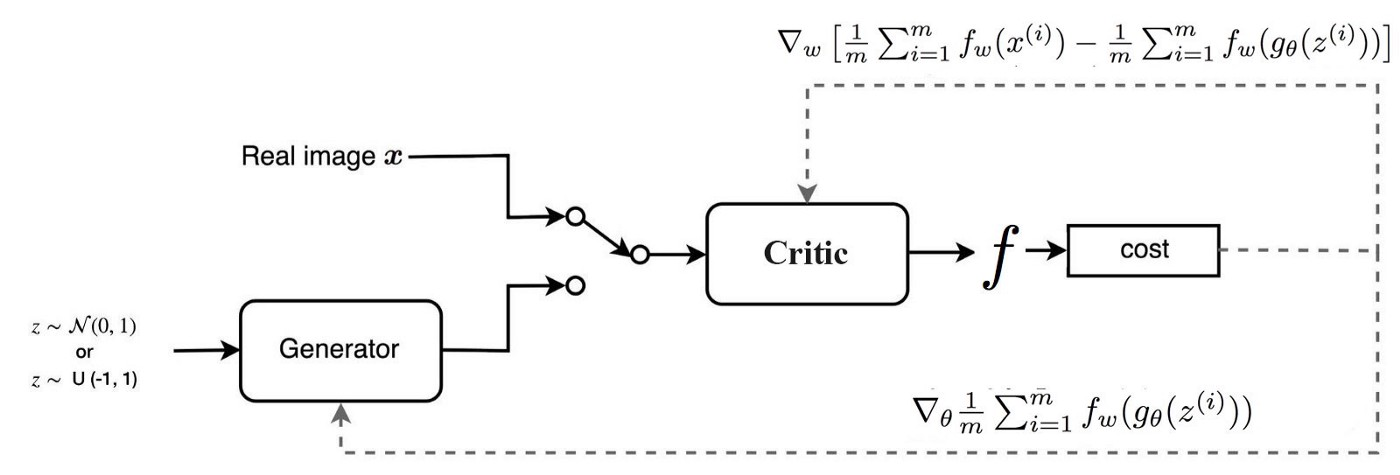

[https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)


> The network design is almost the same with GANs except the critic does not have an output sigmoid function. The major difference is only on the cost function:
> 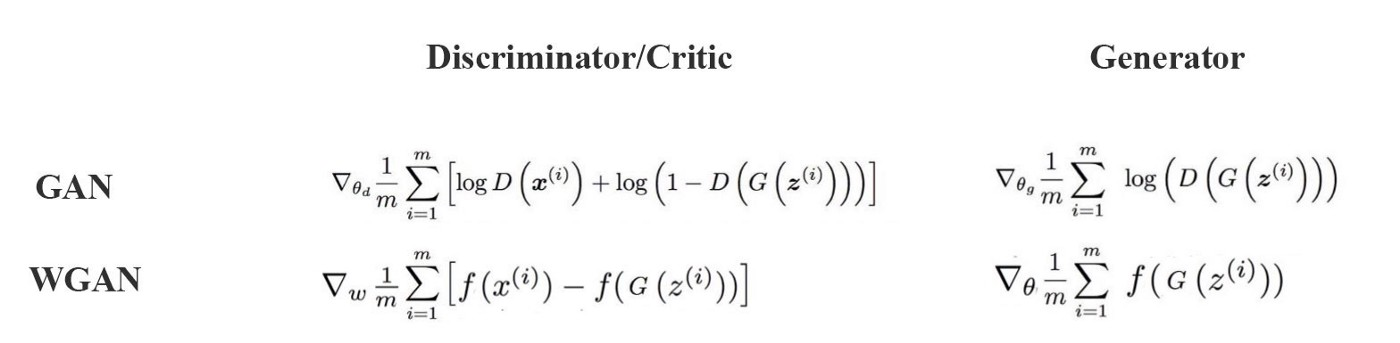

> However, there is one major thing missing. f has to be a 1-Lipschitz function. To enforce the constraint, WGAN applies a very simple clipping to restrict the maximum weight value in f, i.e. the weights of the discriminator must be within a certain range controlled by the hyperparameters c.
 >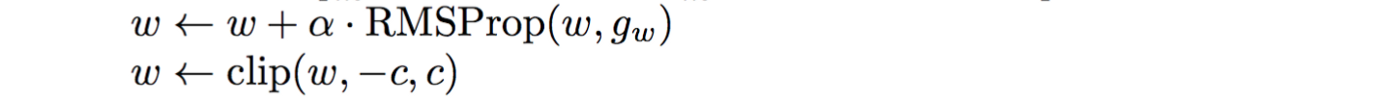



In [ ]:
# import All prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/My Drive/Colab Notebooks/DSC_UI_GAN/Batch1/W2/WGAN"
sample_dir = os.path.join(ROOT, 'sample')
# Make dir if no exist
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
batch_size = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



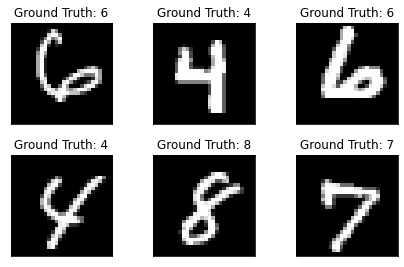

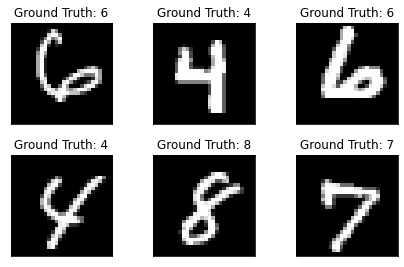

In [ ]:
## Print example
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

##Build Models
##Generator Model

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), -1)
        return image

##Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

##Build network

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)
print(G, D)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

##Train Process

In [ ]:
# optimizer
lr = 0.00005
n_critic =  5
clip_value = 0.01
G_optimizer = torch.optim.RMSprop(params=[p for p in G.parameters() if p.requires_grad], lr=lr)
D_optimizer = torch.optim.RMSprop(params=[p for p in D.parameters() if p.requires_grad], lr=lr)

In [ ]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200
batches_done = 0
list_loss_D = []
list_loss_G = []
for epoch in range(epochs):

    for i, (imgs, _) in enumerate(train_loader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        fake_imgs = G(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(D(real_imgs)) + torch.mean(D(fake_imgs))

        d_loss.backward()
        D_optimizer.step()

        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            G_optimizer.zero_grad()

            # Generate a batch of images
            gen_imgs = G(z)
            # Adversarial loss
            g_loss = -torch.mean(D(gen_imgs))


            g_loss.backward()
            G_optimizer.step()

            # add loss to list
            list_loss_D.append(d_loss.item())
            list_loss_G.append(g_loss.item())
        
        if i % 300 == 0:
            print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

    if epoch % 5 == 0:
        save_image(gen_imgs.view(gen_imgs.size(0), 1, 28, 28), os.path.join(sample_dir, "%d.png" % epoch), nrow=5, normalize=True)

torch.save(G, os.path.join(ROOT, 'G.pt'))
torch.save(D, os.path.join(ROOT, 'D.pt'))

[Epoch 0/200] [Batch 0/600] [D loss: -0.004234] [G loss: -0.497368]
[Epoch 0/200] [Batch 300/600] [D loss: -0.115878] [G loss: -0.763463]
[Epoch 1/200] [Batch 0/600] [D loss: -0.038407] [G loss: -0.748885]
[Epoch 1/200] [Batch 300/600] [D loss: -0.036386] [G loss: -0.654401]
[Epoch 2/200] [Batch 0/600] [D loss: -0.097517] [G loss: -0.486756]
[Epoch 2/200] [Batch 300/600] [D loss: -0.099478] [G loss: -0.483380]
[Epoch 3/200] [Batch 0/600] [D loss: -0.125480] [G loss: -0.463985]
[Epoch 3/200] [Batch 300/600] [D loss: -0.122725] [G loss: -0.512078]
[Epoch 4/200] [Batch 0/600] [D loss: -0.114349] [G loss: -0.520676]
[Epoch 4/200] [Batch 300/600] [D loss: -0.103095] [G loss: -0.538185]
[Epoch 5/200] [Batch 0/600] [D loss: -0.089138] [G loss: -0.532891]
[Epoch 5/200] [Batch 300/600] [D loss: -0.094173] [G loss: -0.535264]
[Epoch 6/200] [Batch 0/600] [D loss: -0.093387] [G loss: -0.526378]
[Epoch 6/200] [Batch 300/600] [D loss: -0.099107] [G loss: -0.492110]
[Epoch 7/200] [Batch 0/600] [D los